In [3]:
# Imports
import os
import datetime

import torch
from torch.utils.data import TensorDataset, Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.pandas.frame import DataFrame
import pyspark.pandas as ps

# Import utils
from utils import get_global_config, build_spark_session, train, evaluate

# Always import wfdb last because it might break jupyter
import wfdb

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay,roc_curve,auc

# Initial setup
cfg = get_global_config()
# Change channel to include 'I' and 'II'
cfg['CHANNEL_NAMES'] = ['HR',
 'RESP',
 'PULSE',
 'PVC Rate per Minute',
 'SpO2',
 'CVP',
 'ST V',
 'NBP Mean',
 'NBP Dias',
 'NBP Sys']
# spark = build_spark_session()

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
cfg['CHANNEL_NAMES']

['HR',
 'RESP',
 'PULSE',
 'PVC Rate per Minute',
 'SpO2',
 'CVP',
 'ST V',
 'NBP Mean',
 'NBP Dias',
 'NBP Sys']

In [92]:
# Defining paths for local
# DATAPATH = '/Users/michaelscott/bd4h/project/data' 
# MIMICPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-1.4'
# DEMOPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-demo-1.4'
# WAVEFPATH = DATAPATH + '/waveform/physionet.org/files/mimic3wdb-matched/1.0'
# OUTPUTPATH = './output'

# function for creating datasets
def create_batch(df, window_size=cfg['WINDOWSIZE'], overlap_pct=cfg['RECORDOVERLAP']):
	# Convert to numpy array of 120 rows each
	# with intersect of 40%
	# Set the window size to 120 and the overlap to 40%
	overlap = int(window_size * overlap_pct)

	# Convert the DataFrame to a numpy array
	# data = df.values
	data = df

	if len(data) == window_size:
		# Convert the list of windows to a numpy array
		# Create a new axis to to specify batch size of 1
		windows = np.array(data)[np.newaxis, :]

	else:
		# Use the rolling method to create the sliding windows
		windows = []
		for i in range(0, len(data) - window_size, window_size - overlap):
			window = data[i:i+window_size]
			# Count number of Nan values in the window
			# If there are any, drop the window
			if window.isnull().sum().sum() == window.count().sum():
				print("dropping empty array")
				pass
			else:
				windows.append(window.fillna(0))
		# Convert the list of windows to a numpy array
		windows = np.array(windows)
		
	# converts from (n, 120, 10) to (n, 10, 120) 
	return np.swapaxes(windows,1,2)

def get_arr(arr, y):
	if arr.shape[0] > 1:
		return np.array([y]*arr.shape[0]).squeeze()
	else:
		return np.array([y]*arr.shape[0])

def load_dataset(x,age_arr,y):
	"""
	:param path: a path to the seizure data CSV file
	:return dataset: a TensorDataset consists of a data Tensor and a target Tensor
	"""
	# Casting in pytorch tensor
	data = torch.from_numpy(x).type(torch.FloatTensor)
	target = torch.from_numpy(y).type(torch.FloatTensor) # BCE with logit expects target to be float. CrossEntropy expects long
	age = torch.from_numpy(age_arr).type(torch.FloatTensor)

	# x[torch.isnan(x)] = 0

	# Need to be of size (N, Cn, L)
	# N: batch size
	# Cn: number of channels
	# L: length of the sequence
	data = data.reshape((data.shape[0], data.shape[1], data.shape[2]))
	dataset = TensorDataset(data, age.float(), target.float())

	return dataset

# Functions for waveform
def get_waveform_path(record_name):
	patient_id = record_name[0:7]
	return cfg['WAVEFPATH'] + f'/{patient_id[0:3]}/{patient_id}/{record_name}'

def plot_waveform(record_name = 'p087675-2104-12-05-03-53n',ca_time_str = '2104-12-05 08:40:00'):
	# Get waveform data
	patient_path = get_waveform_path(record_name)
	record = wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])

	# Select only HR from the plots, not with the channels parameter
	fig = wfdb.plot_wfdb(record=record, title=record_name[0:7], figsize=(10,15), return_fig=True)
	ax_list = fig.axes

	# get time when recording started
	base_time = datetime.datetime.combine(record.__dict__['base_date'], 
							record.__dict__['base_time'])

	# Create datetime using strptime
	ca_time = datetime.datetime.strptime(ca_time_str, '%Y-%m-%d %H:%M:%S')

	# find time delta between base_time and ca_time
	# Convert it to an int that represents the number of seconds
	time_delta = int((ca_time - base_time).total_seconds())

	# Plot a vertical line at time_delta
	if time_delta > 0:
		for ax in ax_list:
			ax.axvline(x=time_delta, color='red', linestyle='--',)
	else:
		# change title of fig
		fig.suptitle('Cardiac Arrest Time is before the start of the recording')

	fig.show()

	print(record.__dict__)

def get_base_time(record_name):
	recordstarttime = record_name[8:]
	recordstarttime = recordstarttime.strip().strip('n')
	return recordstarttime

def get_record(record_name):
	patient_path = get_waveform_path(record_name)
	return wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])

def get_ending_time(record_name):
	"""Ending time is the end time of a record"""
	# Get waveform data
	record = get_record(record_name)
	
	# get time when recording started
	base_time = datetime.datetime.combine(record.__dict__['base_date'], 
							record.__dict__['base_time'])
	
	duration = record.__dict__['sig_len'] * (1/record.__dict__['fs']) 

	# Add duration to base time
	end_time = base_time + datetime.timedelta(seconds=duration)

	record_present = [0 for i in range(len(cfg['CHANNEL_NAMES']))]

	# One hot encode the presence of signals
	for idx, val in enumerate(cfg['CHANNEL_NAMES']):
		if val in record.__dict__['sig_name']:
			record_present[idx] = 1

	return end_time, record_present

""" Model"""
# bookmark
class MyCNN(nn.Module):
	def __init__(self):
		# self.MAGIC_NUMBER = 16*41
		self.MAGICNUM = 103
		super(MyCNN, self).__init__()
		self.conv1 = nn.Conv1d(in_channels=10, out_channels=4, kernel_size=10)
		self.conv2 = nn.Conv1d(in_channels=4, out_channels=1, kernel_size=5)
		self.pool = nn.MaxPool1d(kernel_size=3, stride=1)
		self.out1 = nn.Linear(in_features=567, out_features=1)

		self.dropout = nn.Dropout(0.001)
		self.lstm = nn.LSTM(input_size = self.MAGICNUM, hidden_size=16, num_layers=2)
		self.out = nn.Linear(in_features=16, out_features=1, bias=True)
		self.out2 = nn.Linear(in_features=16, out_features=1, bias=True)

		self.age_fn = nn.Linear(in_features=1, out_features=1, bias=True)
		# Initialize age_fn with a very small weight
		# self.age_fn.weight.data =torch.full((1, 1), 0.000001)
		# self.age_fn.bias.data = torch.full((1, 1), 1.)
		# torch.nn.init.constant_(self.age_fn.weight, .0000001)
		# torch.nn.init.constant_(self.age_fn.bias, 1)

	def forward(self, x, age):
		# print(x.size())
		x = torch.tanh(self.conv1(x))
		# print(x.size())
		x = self.pool(x)
		x=self.dropout(x)
		# print(x.size())
		x = torch.tanh(self.conv2(x))
		# print(x.size())
		x = self.pool(x)
		# print(x.size())
		x = self.dropout(x)
		# print(x.size())
		x = x.view(-1, self.MAGICNUM)
		x,_ = self.lstm(x)

		## version without age
		## this version works! Creates AUC of around 0.66
		# x = self.out(x).squeeze(1) 

		## version with age
		# x = torch.sigmoid(self.out(x))
		# print(age)
		# age_scale = torch.relu(self.age_fn(age.unsqueeze(1))) # add an additional dimension
		# print(age_scale)
		# x = (x*age_scale).squeeze(1) # squeeze 
		# print(x)

		# new version I'm trying
		# x = torch.sigmoid(self.out(x).squeeze(1))
		# print(age)
		# x = torch.sigmoid(self.out(x))
		# age_scale = torch.relu(age.unsqueeze(1) * 0.0001 + 1)
		# x = (x*age_scale).squeeze(1) # squeeze 

		# new version I'm trying
		# print(x.shape)
		# x = torch.sigmoid(self.out(x))
		# print(age.unsqueeze(1))
		# print(age.unsqueeze(1).shape)
		# age_scale = torch.relu(age.unsqueeze(1) * 0.0001 + 1)
		# print(age_scale)
		# print(x*age_scale)
		# x = (x*age_scale).squeeze(1) # squeeze 
		# print(x)

		# print(age)

		# new version I'm trying this still works!!
		x = self.out(x)
		age_scale = torch.relu(age.unsqueeze(1) * 0.00000001 + 1)
		x = x * age_scale
		x = x.squeeze(1) 
		

		# this stops working...
		# x = torch.sigmoid(self.out(x))
		# age_scale = torch.relu(age.unsqueeze(1) * 0.0001 + 1)
		# x = x * age_scale
		# x = x.squeeze(1) 

		# this version does NOT work.
		# x = self.out(x)
		# input_age_scale = self.age_fn(age.unsqueeze(1))
		# age_scale = torch.relu(input_age_scale)
		# x = x * age_scale
		# x = x.squeeze(1) 
		
		return x

# Lesson on why you need age.unsqueeze(1):
# The error is most likely caused by the fact that age is a tensor of shape (32,),
#  which means it has 32 elements but is not a matrix. However, self.age_fn is a linear layer 
# that expects a matrix as input. Specifically, the in_features parameter is set to 1, which means 
# it expects a matrix of size (batch_size, 1).

# When you pass age to self.age_fn, it is implicitly expanded to a matrix of size (batch_size, 32)
#  by adding a singleton dimension at the end (since age has size (32,)), which is not what you want. 
# Instead, you should first unsqueeze the tensor along the second dimension (i.e., age.unsqueeze(1)) 
# to get a matrix of size (batch_size, 1), and then pass it to self.age_fn.

In [6]:
def get_patient_age(patient_id, currentdate):
    patient_df = pd.read_csv(f"{cfg['DATAPATH']}/patients_age.csv")
    dob = patient_df.query(f"SUBJECT_ID=={patient_id}")['dob'].values[0]
    # Convert to datetime.datetime object
    dob = datetime.datetime.strptime(dob, '%Y-%m-%d')
    age = (currentdate - dob).days/365
    return age 

def get_record_df(record_name, base_time=None, ca_time=None):
    # Retrieve record
    record = get_record(record_name)
    record_df = record.to_dataframe()

    # If first_index is greater than base_time
    if record_df.first_valid_index() >= base_time: 
        actual_BASETIME = record_df.first_valid_index() 
    else:
        actual_RECORDSTARTTIME = base_time

    # get actual CA time as the final valid index of the entire dataframe
    # if the patient is dead
    if not ca_time:
        actual_CATIME = record_df.last_valid_index()
    else:
        actual_CATIME = ca_time

    # get actual splittime
    actual_CASTARTTIME = actual_CATIME - datetime.timedelta(hours=2)

    actual_CAENDTIME = actual_CATIME - datetime.timedelta(minutes=5)

    # retrieve the first non-null record using the loc method
    # record_df = record_df.loc[actual_RECORDSTARTTIME:actual_STARTTIME]
    # record_df = record_df.drop([actual_CAENDTIME:actual_CATIME+datetime.timedelta(hours=1.5)])
    record_df = record_df[~((record_df.index >= actual_CATIME) & (record_df.index <= actual_CAENDTIME + datetime.timedelta(hours=1.5)))]

    for channel in cfg['CHANNEL_NAMES']:
        if channel not in record_df.columns:
            record_df[channel.replace(' ','_')] = 0

    # Sample at 5 second interval
    # take instantaneous value
    record_df = record_df.resample('5S').first()
    
    # perform preprocessing
    record_df = record_df.interpolate(method='linear')

    # define positive and negative
    negative_df_1 = record_df.loc[:actual_CASTARTTIME]

    # negative_df_2 is 1.5 hour after actual_FINISHTIME
    negative_df_2 = record_df.loc[actual_CATIME+datetime.timedelta(hours=1.5):]

    # combine negative_df and negative_df_2
    negative_df = pd.concat([negative_df_1, negative_df_2])

    positive_df = record_df.loc[actual_CASTARTTIME:actual_CAENDTIME,:]

    return record_name[0:7], positive_df, negative_df

def get_arrays(positive_df, negative_df, age): # Create x, y, and a arr for negative
    if len(positive_df)<120 and len(negative_df)<120:
        print("None obtained")
        return np.empty((0,10,120)), np.empty(0), np.empty(0)
    
    if len(positive_df)<120:
        print("Only negative")
        x_negative_arr = create_batch(negative_df)
        y_negative_arr = get_arr(x_negative_arr,0)
        a_negative_arr = get_arr(x_negative_arr,age)
        return x_negative_arr,y_negative_arr,a_negative_arr

    # Create x, y, and a arr for positive
    if len(negative_df)<120:
        print("Only positive")
        x_positive_arr = create_batch(positive_df)
        y_positive_arr = get_arr(x_positive_arr,1)
        a_positive_arr = get_arr(x_positive_arr,age)
        return x_positive_arr,y_positive_arr,a_positive_arr

    # Concatenating all arrays
    else:
        print("Both")
        x_negative_arr = create_batch(negative_df)
        y_negative_arr = get_arr(x_negative_arr,0)
        a_negative_arr = get_arr(x_negative_arr,age)

        x_positive_arr = create_batch(positive_df)
        y_positive_arr = get_arr(x_positive_arr,1)
        a_positive_arr = get_arr(x_positive_arr,age)

        x_arr = np.concatenate([x_negative_arr,x_positive_arr])
        y_arr = np.concatenate([y_negative_arr,y_positive_arr])
        a_arr = np.concatenate([a_negative_arr,a_positive_arr])
    
    return x_arr, y_arr, a_arr


In [5]:
d = {}

for row in waveform_df.iterrows():
    try:
        record = get_record(row[1]['RECORDNAME'])
        # record = wfdb.rdrecord(row['RECORDNAME'])
        for sig_name in record.__dict__['sig_name']:
            if sig_name not in d:
                d[sig_name] = 1
            else:
                d[sig_name]+=1
    except Exception as e:
        print(e)
        print(row)
        continue

d

# {'HR': 28,
#  'PULSE': 28,
#  'NBP Sys': 11,
#  'NBP Dias': 11,
#  'NBP Mean': 11,
#  'RESP': 28,
#  'ST II': 5,
#  'ST V': 13,
#  'SpO2': 14,
#  'PVC Rate per Minute': 15,
#  'Rhythm Status': 15,
#  'Ectopic Status': 15,
#  'Ectopic Count': 15,
#  'ABP SYS': 11,
#  'ABP DIAS': 11,
#  'ABP MEAN': 11,
#  'CVP': 13,
#  'PAP SYS': 6,
#  'PAP DIAS': 6,
#  'PAP MEAN': 6,
#  'NBP SYS': 12,
#  'NBP DIAS': 12,
#  'NBP MEAN': 12,
#  'ST-III': 10,
#  'ST-V': 11,
#  '%SpO2': 13,
#  'PlsNBP': 10,
#  '[63131]': 12,
#  'Atrial Paced Beat Count': 12,
#  'Vent Paced Beat Count': 12,
#  'Dual Paced Beat Count': 12,
#  'Paced Beat Count': 12,
#  'Normal Beat Count': 12,
#  'SVPB Count': 12,
#  'PVC Count': 12,
#  'SV Count': 12,
#  'Missed Beat Count': 12,
#  'All Beat Count': 12,
#  'SVPB Run Count': 12,
#  'S Rate Max': 12,
#  'S Rate Min': 12,
#  'Paced Run Count': 12,
#  'P Rate Max': 12,
#  'P Rate Min': 12,
#  'VQ Run Count': 12,
#  'PVC Run Count': 12,
#  'V Rate Max': 12,
#  'V Rate Min': 12,
#  'Max PVC Run': 12,
#  'R On T Count': 12,
#  'PVC Pair Count': 12,
#  'Pacer Not Pace Count': 12,
#  'Pacer Not Capture Count': 12,
#  'Multiform Count': 12,
#  'Irregular HR Percent': 12,
#  'pNN50 Percent': 12,
#  'HR Variability': 12,
#  'Poor Signal': 12,
#  'Trigeminy Percent': 12,
#  'Bigeminy Percent': 12,
#  'Paced Beat Percent': 12,
#  'Atrial Paced Percent': 12,
#  'Dual Paced Percent': 12,
#  'Vent Paced Percent': 12,
#  'CO': 5,
#  'Tblood': 5,
#  'C.I.': 3,
#  'ABP': 12,
#  'ABP Sys': 12,
#  'ABP Dias': 12,
#  'ABP Mean': 12,
#  'ST III': 12,
#  'ART': 3,
#  'ART Sys': 3,
#  'ART Dias': 3,
#  'ART Mean': 3,
#  'AOBP': 1,
#  'AOBP Sys': 1,
#  'AOBP Dias': 1,
#  'AOBP Mean': 1,
#  'TEMP': 5,
#  'ST-I': 1,
#  'ST-II': 2,
#  'ST-aVR': 1,
#  'ST-aVL': 1,
#  'ST-aVF': 1,
#  'Trect': 1,
#  'Temp Rect': 2,
#  'ART SYS': 4,
#  'ART DIAS': 4,
#  'ART MEAN': 4,
#  'NBP': 9,
#  'UAP': 1,
#  'UAP Sys': 1,
#  'UAP Dias': 1,
#  'UAP Mean': 1,
#  'PAP': 1,
#  'PAP Sys': 1,
#  'PAP Dias': 1,
#  'PAP Mean': 1,
#  'ST I': 4,
#  'ST AVR': 4,
#  'ST AVL': 4,
#  'ST AVF': 4,
#  'ST MCL': 4,
#  'ICP': 2,
#  'CPP': 2,
#  'Ao SYS': 1,
#  'Ao DIAS': 1,
#  'Ao MEAN': 1,
#  'PAWP': 1,
#  'Tnaso': 2,
#  'T1': 2}

NameError: name 'waveform_df' is not defined

In [ ]:
# 

# First model experiment

In [80]:
# Use patient 70723 as an example

# Information needed
# - SUBJECTID
# - STARTTIME (Cardiac arrest time)
# - RECORDNAME
# - RECORDSTARTTIME
# - ENDTIME 
# - Age

# We assume that all these information are conveninently stored in a table for us, 
# and we will start from there. Here, we define them as constants.
# Later we will move them to a table and read from there.

# Defining constants
SUBJECTID = 70723
RECORDNAME = 'p070723-2163-11-18-16-28n'
RECORDSTARTTIME = get_base_time(RECORDNAME)
ENDTIME, RECORD_PRESENT = get_ending_time(RECORDNAME)
CATIME = datetime.datetime.strptime('2163-11-20 11:37:20', '%Y-%m-%d %H:%M:%S') # ORIGINALLY 2163-11-18 15:06:00 (TIME OF NOTEEVENTS)
SPLITTIME = CATIME - datetime.timedelta(hours=2)
FINISHTIME = SPLITTIME - datetime.timedelta(minutes=5)
AGE = get_patient_age(70723, CATIME)

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_56708/3665699803.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p070723-2163-11-18-16-28n', 'n_sig': 5, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 158241, 'base_time': datetime.time(16, 28, 34), 'base_date': datetime.date(2163, 11, 18), 'comments': ['Location: micu/sicu'], 'sig_name': ['HR', 'RESP', 'PULSE', 'SpO2', 'CVP'], 'p_signal': array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['3476173n.dat', '3476173n.dat', '3476173n.dat', '3476173n.dat', '3476173n.dat'], 'fmt': ['16', '16', '16', '16', '16'], 'samps_per_frame': [1, 1, 1, 1, 1], 'skew': [None, None, None, None, None], 'byte_offset': [None, None, None, None, None], 'adc_gain': [1.0, 1.0, 1.0, 1.0, 1.0], 'baseline': [0, 0, 0, 0, 0], 'units': ['bpm', 'pm', 'bpm', '%', 'mmHg'], 'adc_res': [16, 16, 16, 16, 16], 'adc_zero'

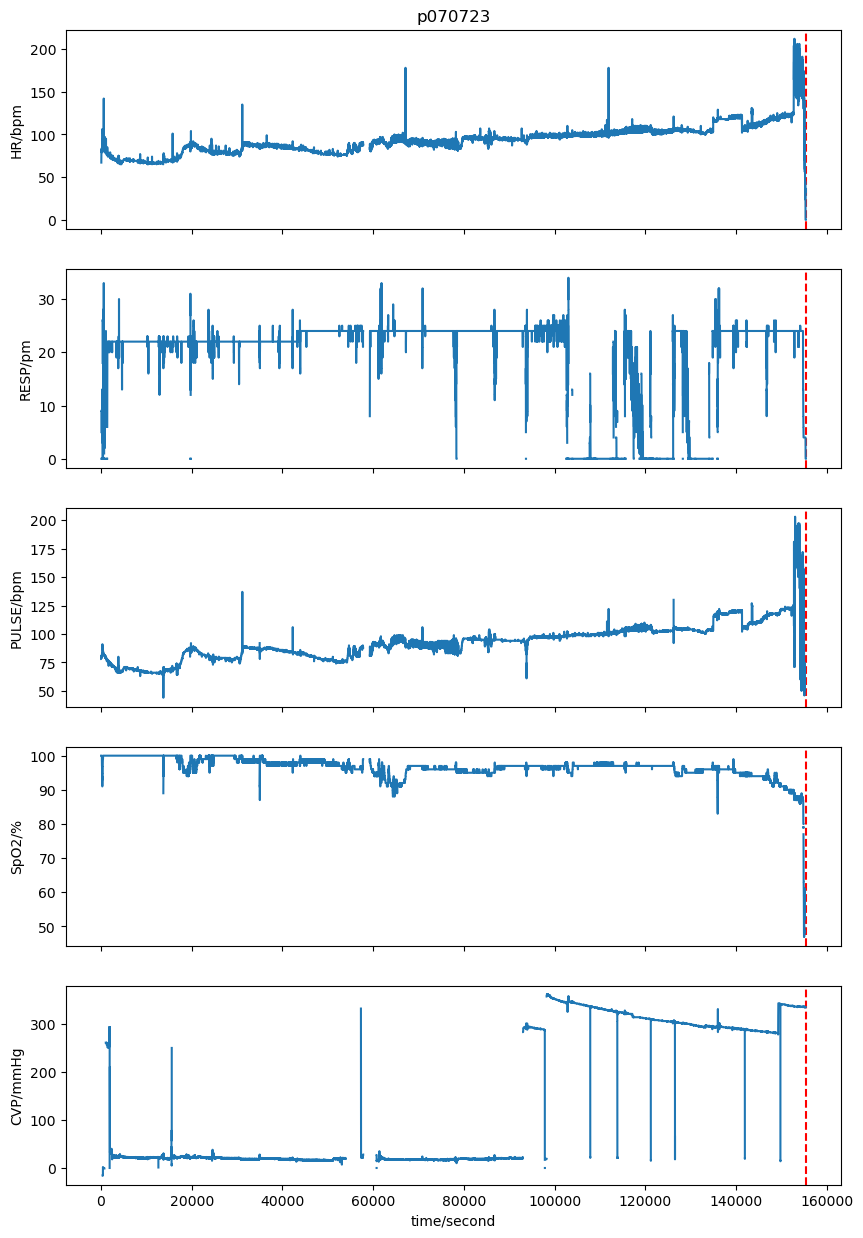

In [6]:
plot_waveform(ca_time_str = CATIME.strftime('%Y-%m-%d %H:%M:%S'), record_name = RECORDNAME)

In [241]:
# # Retrieve record
# record = get_record(RECORDNAME)
# record_df = record.to_dataframe()

# # get the index of the first non-null value in the DataFrame
# actual_BASETIME = record_df.first_valid_index()

# # get actual CA time as the final valid index of the entire dataframe
# # if the patient is dead
# actual_STARTTIME = record_df.last_valid_index()

# # get actual splittime
# actual_SPLITTIME = actual_STARTTIME - datetime.timedelta(hours=2)

# actual_ENDTIME = actual_STARTTIME - datetime.timedelta(minutes=5)

# # retrieve the first non-null record using the loc method
# record_df = record_df.loc[actual_RECORDSTARTTIME:actual_STARTTIME]

# for channel in cfg['CHANNEL_NAMES']:
#     if channel not in record_df.columns:
#         record_df[channel.replace(' ','_')] = 0

# # Sample at 5 second interval
# # take instantaneous value
# record_df = record_df.resample('5S').first()

# # perform preprocessing
# record_df = record_df.interpolate(method='linear').fillna(0)

# # can also consider this alternative:
# # record_df = record_df.resample('5S').mean()

# # Split into two parts:
# # 1. Long before cardiac arrest (anytime - 2hours before STARTTIME)
# # 2. Immediately before cardiac arrest (2 hours - 5 minutes before STARTTIME)
# # record_df['y'] = 0 
# # record_df.loc[:actual_SPLITTIME,'y'] = 0
# # record_df.loc[actual_SPLITTIME:actual_FINISHTIME,'y']=1

# # Drop the remaninig records (last 5 minutes before cardiac arrest)
# # Though we can consider it as +ve sample actually if we lack training data
# # record_df = record_df.loc[:actual_FINISHTIME]

# # define positive and negative
# negative_df = record_df.loc[:actual_SPLITTIME]
# positive_df = record_df.loc[actual_SPLITTIME:actual_FINISHTIME,:]

patientid, positive_df, negative_df = get_record_df(record_name='p070723-2163-11-18-16-28n', 
                                         base_time=None, 
                                         ca_time=datetime.datetime.strptime('2163-11-20 11:37:20', '%Y-%m-%d %H:%M:%S'))

In [242]:
display(positive_df)
display(negative_df)

TypeError: 'RocCurveDisplay' object is not callable

In [243]:
AGE = 65

# Create x, y, and a arr for negative
x_negative_arr = create_batch(negative_df)
y_negative_arr = get_arr(x_negative_arr,0)
a_negative_arr = get_arr(x_negative_arr,AGE)

# Create x, y, and a arr for positive
x_positive_arr = create_batch(positive_df)
y_positive_arr = get_arr(x_positive_arr,1)
a_positive_arr = get_arr(x_positive_arr,AGE)

# Concatenating all arrays
x_arr = np.concatenate([x_negative_arr,x_positive_arr])
y_arr = np.concatenate([y_negative_arr,y_positive_arr])
a_arr = np.concatenate([a_negative_arr,a_positive_arr])

# converts from (n, 120, 10) to (n, 10, 120) 
# x_arr = np.swapaxes(x_arr,1,2)

# Split between train + test
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.3, random_state=24)
sss.get_n_splits(x_arr, y_arr)
train_index, valtest_index = next(sss.split(x_arr, y_arr)) 

X_train, X_valtest = x_arr[train_index], x_arr[valtest_index] 
a_train, a_valtest = a_arr[train_index], a_arr[valtest_index] 
y_train, y_valtest = y_arr[train_index], y_arr[valtest_index]

# Split between val and test
sss = ShuffleSplit(n_splits=1, test_size=0.5, random_state=24)
sss.get_n_splits(X_valtest, y_valtest)
val_index, test_index = next(sss.split(X_valtest, y_valtest)) 

X_val, X_test = X_valtest[val_index], X_valtest[test_index] 
a_val, a_test = a_valtest[val_index], a_valtest[test_index] 
y_val, y_test = y_valtest[val_index], y_valtest[test_index]

# Create dataloader
dataset = load_dataset(x_arr, a_arr, y_arr)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

# Print the data out
# for i, (input, age, target) in enumerate(data_loader):
#     print(input,age,target)

In [10]:
print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (299, 10, 120)
Validation shape: (64, 10, 120)
Testing shape: (65, 10, 120)


In [11]:
pd.DataFrame(X_test[0].T)

,0,1,2,3,4,5,6,7,8,9
0,78.0,22.0,79.0,0.0,100.0,20.0,0.0,0.0,0.0,0.0
1,78.0,22.0,78.0,0.0,100.0,20.0,0.0,0.0,0.0,0.0
2,78.0,22.0,78.0,0.0,100.0,20.0,0.0,0.0,0.0,0.0
3,78.0,22.0,78.0,0.0,100.0,21.0,0.0,0.0,0.0,0.0
4,78.0,22.0,78.0,0.0,100.0,20.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
115,77.0,22.0,78.0,0.0,100.0,20.0,0.0,0.0,0.0,0.0
116,78.0,22.0,78.0,0.0,100.0,20.0,0.0,0.0,0.0,0.0
117,78.0,22.0,78.0,0.0,100.0,20.0,0.0,0.0,0.0,0.0
118,78.0,22.0,78.0,0.0,100.0,20.0,0.0,0.0,0.0,0.0


In [12]:
data_df = pd.DataFrame(X_test[0].T)

In [13]:
# Creating a mock x test file
data_df.to_csv(cfg['EXPLOREPATH']+'/X.TESTINPUT',index=False)

In [70]:
# from plots import plot_learning_curves, plot_confusion_matrix

#TODO: https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection

# # Set a correct path to the seizure data file you downloaded
# PATH_TRAIN_FILE = "../data/seizure/seizure_train.csv"
# PATH_VALID_FILE = "../data/seizure/seizure_validation.csv"
# PATH_TEST_FILE = "../data/seizure/seizure_test.csv"

# # Path for saving model
PATH_OUTPUT = "../model/"
# os.makedirs(PATH_OUTPUT, exist_ok=True)

# # Some parameters
# MODEL_TYPE = 'MLP'  # TODO: Change this to 'MLP', 'CNN', or 'RNN' according to your task
NUM_EPOCHS = 100
BATCH_SIZE = 16
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

model = MyCNN()
save_file = 'MyCNN5.pth'

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

train_dataset = load_dataset(X_train, a_train, y_train)
valid_dataset = load_dataset(X_val,   a_val,   y_val)
test_dataset  = load_dataset(X_test,  a_test,  y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Summary: {pytorch_total_params}")

# Delete me
def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f"{name}: {params}")
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, cfg['MODELPATH'], _use_new_zipfile_serialization=False)

# plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(cfg['MODELPATH'])
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)


Model Summary: 7028
conv1.weight: 200
conv1.bias: 4
conv2.weight: 20
conv2.bias: 1
lstm.weight_ih_l0: 3456
lstm.weight_hh_l0: 1024
lstm.bias_ih_l0: 64
lstm.bias_hh_l0: 64
lstm.weight_ih_l1: 1024
lstm.weight_hh_l1: 1024
lstm.bias_ih_l1: 64
lstm.bias_hh_l1: 64
out.weight: 16
out.bias: 1
age_fn.weight: 1
age_fn.bias: 1
Total Trainable Params: 7028


RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 0

That was for training the model. Now, we expect the model to take in some input. How will the input be?

Making an inference on one patient's one waveform data

In [233]:

def load_dataset_production(x_arr, age_arr):
	"""
	:param path: a path to the seizure data CSV file
	:return dataset: a TensorDataset consists of a data Tensor and a target Tensor
	"""
	# Casting in pytorch tensor
	data = torch.from_numpy(x_arr).type(torch.FloatTensor)
	age = torch.from_numpy(age_arr).type(torch.FloatTensor)

	# x[torch.isnan(x)] = 0

	# Need to be of size (N, Cn, L)
	# N: batch size
	# Cn: number of channels
	# L: length of the sequence
	# data = data.reshape((data.shape[0], data.shape[1], data.shape[2]))
	dataset = TensorDataset(data, age.float())

	return dataset


In [18]:
cfg['MODELPATH'] = '../model/MyCNN5.pth'

# Loading the model
model = torch.load(cfg['MODELPATH'])

model.eval()

# Assume that data_df comes in as a pandas dataframe
data_df = pd.read_csv(cfg['EXPLOREPATH']+'/X.TESTINPUT')

# Generate an feature array
x_arr = create_batch(data_df, window_size=cfg['WINDOWSIZE'], overlap_pct = 0)

# converts from (n, 120, 10) to (n, 10, 120) 
print(x_arr.shape)
# x_arr = np.swapaxes(x_arr,1,2)

# generate an age array of the same size as x_arr
a_arr = get_arr(x_arr,AGE)

with torch.no_grad():
	x_arr = torch.from_numpy(x_arr).type(torch.FloatTensor).to(device).float()
	a_arr = torch.from_numpy(a_arr).type(torch.FloatTensor).unsqueeze(0).to(device).float()
	output = model(x_arr, a_arr)
	x_arr=x_arr.to(device)
	a_arr=a_arr.to(device)
	y = torch.sigmoid(output).detach().to('cpu')
	y_pred = y.round().long().numpy().tolist()
	y_prob = y.numpy().tolist()

	print(y_prob)
	print(y_pred)
# Prove that this is the same results as the evaluation set 

(1, 10, 120)
[3.005064641570243e-09]
[0]


Finding a way of uploading the age to "patients" in dataframe

# Actual Training
bookmark


In [7]:
# Using the data from patients_waveform.csv
waveform_df=pd.read_csv(F'{cfg["DATAPATH"]}/patients_waveform.csv', parse_dates=['CATIME','RECORDSTARTTIME','RECORDENDTIME'])
# valid_records_df = waveform_df.query("RECORDSTARTTIME<=STARTTIME & STARTTIME<=FINISHTIME")[['RECORDNAME','RECORDSTARTTIME','STARTTIME','FINISHTIME','SPLIT']]
valid_records_df = waveform_df[['RECORDNAME','RECORDSTARTTIME','CATIME','RECORDENDTIME','SPLIT']]

# remove timestamp awareness from RECORDSTARTTIME and STARTTIME
valid_records_df['RECORDSTARTTIME'] = valid_records_df['RECORDSTARTTIME'].dt.tz_localize(None)
valid_records_df['CATIME'] = valid_records_df['CATIME'].dt.tz_localize(None)
valid_records_df['RECORDENDTIME'] = valid_records_df['RECORDENDTIME'].dt.tz_localize(None)
valid_records_df.sort_values(by='RECORDNAME')

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_33251/2123388304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_records_df['RECORDSTARTTIME'] = valid_records_df['RECORDSTARTTIME'].dt.tz_localize(None)
/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_33251/2123388304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_records_df['CATIME'] = valid_records_df['CATIME'].dt.tz_localize(None)
/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_33251/2123388304.py:9: Se

,RECORDNAME,RECORDSTARTTIME,CATIME,RECORDENDTIME,SPLIT
0,p041035-2135-02-06-08-02n,2135-02-06 08:02:00,2135-02-06 16:27:00,2135-02-06 11:14:00,val
1,p043926-2197-05-14-15-06n,2197-05-14 15:06:00,2197-05-14 17:28:00,2197-05-17 17:16:00,train
2,p044298-2187-06-28-23-57n,2187-06-28 23:57:00,2187-06-28 19:00:00,2187-07-03 14:21:00,train
3,p046154-2196-07-29-02-30n,2196-07-29 02:30:00,2196-07-29 06:00:00,2196-07-29 06:47:00,val
4,p046927-2130-03-10-11-48n,2130-03-10 11:48:00,2130-03-10 16:28:00,2130-03-11 13:29:00,test
5,p050015-2138-12-20-19-42n,2138-12-20 19:42:00,2138-12-20 23:53:00,2138-12-20 22:06:00,val
6,p052529-2184-03-10-11-01n,2184-03-10 11:01:00,2184-03-10 05:10:00,2184-03-10 12:50:00,val
7,p052529-2184-03-10-13-16n,2184-03-10 13:16:00,2184-03-10 05:10:00,2184-03-11 12:25:00,train
8,p054183-2165-09-27-20-05n,2165-09-27 20:05:00,2165-09-27 21:01:00,2165-09-27 21:13:00,train
9,p056697-2164-08-21-06-43n,2164-08-21 06:43:00,2164-08-21 06:55:00,2164-08-24 08:54:00,train


In [8]:
# 'p096305-2158-11-01-12-24n'
# recordstarttime
# recordstarttime  '2158-11-01T12:24:00.000+08:00'
# finishtime'2158-11-02T10:35:00.000+08:00'
# starttime '2158-11-01T10:29:00.000+08:00'
# get_record_df(row['RECORDNAME'], row['RECORDSTARTTIME'], row['STARTTIME'])

In [8]:
x_train_arr, x_val_arr, x_test_arr  = np.empty((0,10,120)),np.empty((0,10,120)),np.empty((0,10,120))
y_train_arr, y_val_arr, y_test_arr = np.empty((0)),np.empty((0)),np.empty((0))
a_train_arr, a_val_arr, a_test_arr = np.empty((0)),np.empty((0)),np.empty((0))
id_train_arr, id_val_arr, id_test_arr = np.empty((0)),np.empty((0)),np.empty((0))

for idx, row in valid_records_df.iterrows():
    print(row['RECORDNAME'])
    patient_id, positive_df, negative_df = get_record_df(row['RECORDNAME'], row['RECORDSTARTTIME'], row['CATIME'])
    age = get_patient_age(int(patient_id[1:]), row['RECORDSTARTTIME'])
    if age >= 80:
        age = 80.0
    if age <= 15:
        age = 15.0
    # age = 65.0
    x_arr, y_arr, a_arr = get_arrays(positive_df, negative_df, age)
    id_arr = np.full((x_arr.shape[0]), patient_id)
    split = row['SPLIT']
    if split == 'train':
        x_train_arr=np.concatenate([x_train_arr,x_arr])
        y_train_arr=np.concatenate([y_train_arr,y_arr])
        a_train_arr=np.concatenate([a_train_arr,a_arr])
        id_train_arr=np.concatenate([id_train_arr,id_arr])

    elif split == 'val':
        x_val_arr=np.concatenate([x_val_arr,x_arr])
        y_val_arr=np.concatenate([y_val_arr,y_arr])
        a_val_arr=np.concatenate([a_val_arr,a_arr])
        id_val_arr=np.concatenate([id_val_arr,id_arr])

    elif split == 'test':
        x_test_arr=np.concatenate([x_test_arr,x_arr])
        y_test_arr=np.concatenate([y_test_arr,y_arr])
        a_test_arr=np.concatenate([a_test_arr,a_arr])
        id_test_arr=np.concatenate([id_test_arr,id_arr])
    else:
        print("error")

p041035-2135-02-06-08-02n
Only negative
p043926-2197-05-14-15-06n
Both
p044298-2187-06-28-23-57n
Only negative
p046154-2196-07-29-02-30n
Both
p046927-2130-03-10-11-48n
Both
p050015-2138-12-20-19-42n
Both
p052529-2184-03-10-11-01n
Only negative
p052529-2184-03-10-13-16n
Only negative
p054183-2165-09-27-20-05n
Only positive
p056697-2164-08-21-06-43n
Only negative
p060659-2128-05-24-01-01n
Only negative
p062323-2189-10-01-00-11n
Both
p063762-2181-12-04-03-58n
Both
p070723-2163-11-18-16-28n
Only negative
p082104-2177-04-29-16-16n
Both
p082512-2114-12-22-08-46n
None obtained
p082512-2114-12-22-09-16n
Both
p083873-2143-04-16-06-49n
Both
p086678-2196-06-07-00-34n
Both
p087675-2104-12-05-03-53n
Both
p094255-2139-07-30-15-58n
Both
p096060-2112-12-16-14-20n
Both
p096305-2158-11-01-12-24n
Only negative
p099756-2191-12-23-02-00n
Both


In [9]:
# Create dataloader
dataset = load_dataset(x_arr, a_arr, y_arr)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

In [10]:
print(x_train_arr.shape)
print(x_val_arr.shape)
print(x_test_arr.shape)

print(y_train_arr.shape)
print(y_val_arr.shape)
print(y_test_arr.shape)

print(a_train_arr.shape)
print(a_val_arr.shape)
print(a_test_arr.shape)

(6370, 10, 120)
(464, 10, 120)
(861, 10, 120)
(6370,)
(464,)
(861,)
(6370,)
(464,)
(861,)


In [11]:
print(len(y_train_arr))
print(len(y_val_arr))
print(len(y_test_arr))

print(y_train_arr.sum())
print(y_val_arr.sum())
print(y_test_arr.sum())


6370
464
861
103.0
55.0
59.0


In [16]:
x_train_arr.shape

(6370, 10, 120)

In [102]:
# Perform resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

sampling_strategy = 0.5 
# Reshape 3D to 2D
X_2d = x_train_arr.reshape(x_train_arr.shape[0], -1)  
smote_enn = RandomOverSampler(random_state=42, sampling_strategy = sampling_strategy)

# Add element in b to the last as the final element of a
X_2d = np.array([np.append(a,b) for a,b in zip(X_2d, a_train_arr)])
x_train_resampled, y_train_resampled = smote_enn.fit_resample(X_2d, y_train_arr)

# Getting the age and X again
a_train_resampled = x_train_resampled[:,-1]
x_train_resampled = x_train_resampled[:,:-1]
x_train_resampled = np.reshape(x_train_resampled, (x_train_resampled.shape[0], 10, 120))

print(f'New x size: {len(y_train_resampled)}. New positive size: {y_train_resampled.sum()}')

New x size: 9400. New positive size: 3133.0


In [103]:
# Reshape 3D to 2D
X_2d = x_val_arr.reshape(x_val_arr.shape[0], -1)  
smote_enn = RandomOverSampler(random_state=42,sampling_strategy = sampling_strategy)

# Add element in b to the last as the final element of a
X_2d = np.array([np.append(a,b) for a,b in zip(X_2d, a_val_arr)])
x_val_resampled, y_val_resampled = smote_enn.fit_resample(X_2d, y_val_arr)

# Getting the age and X again
a_val_resampled = x_val_resampled[:,-1]
x_val_resampled = x_val_resampled[:,:-1]
x_val_resampled = np.reshape(x_val_resampled, (x_val_resampled.shape[0], 10, 120))

print(f'New x size: {len(y_val_resampled)}. New positive size: {y_val_resampled.sum()}')

New x size: 613. New positive size: 204.0


In [12]:
pip install focal_loss_torch

Note: you may need to restart the kernel to use updated packages.


In [109]:
num_positives = y_train_resampled.sum()
num_total = len(x_train_resampled)
# num_positives = y_train_arr.sum()
# num_total = len(y_train_arr)
num_negatives = num_total - num_positives
num_negatives

6267.0

In [110]:
# bookmark
# from plots import plot_learning_curves, plot_confusion_matrix
#TODO: https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection

import torch
from imblearn.combine import SMOTEENN
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
# Path for saving model
PATH_OUTPUT = "../model/"

# Some parameters
NUM_EPOCHS = 50
BATCH_SIZE = 128 
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

model = MyCNN()
save_file = 'MyCNN8.pth'

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

# https://stackoverflow.com/questions/68611397/pos-weight-in-binary-cross-entropy-calculation/68769210#68769210
num_positives = y_train_resampled.sum()
num_total = len(x_train_resampled)
# num_positives = y_train_arr.sum()
# num_total = len(y_train_arr)
num_negatives = num_total - num_positives
pos_weight  =torch.tensor(num_negatives / num_positives)
print(f"pos_weight is {pos_weight}")
# weight = torch.tensor([num_negatives / num_total, num_positives/num_total])

# Loading into dataset
train_dataset = load_dataset(x_train_resampled, a_train_resampled, y_train_resampled)
valid_dataset = load_dataset(x_val_resampled,   a_val_resampled,   y_val_resampled)

# train_dataset = load_dataset(x_train_arr, a_train_arr, y_train_arr)
# valid_dataset = load_dataset(x_val_arr,   a_val_arr,   y_val_arr)
test_dataset  = load_dataset(x_test_arr,  a_test_arr,  y_test_arr)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Summary: {pytorch_total_params}")

# Delete me
def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f"{name}: {params}")
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
# count_parameters(model)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# optimizer = optim.Adagrad(model.parameters(), lr = 0.005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc, best_val_loss = 0.0, 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch, print_freq=50)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion, print_freq=50)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	# is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	# if is_best:
	# 	best_val_acc = valid_accuracy
	# 	torch.save(model, cfg['MODELPATH'], _use_new_zipfile_serialization=False)

	is_best = valid_loss < best_val_loss
	if is_best:
		best_val_loss = valid_loss
		torch.save(model, cfg['MODELPATH'], _use_new_zipfile_serialization=False)

# plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(cfg['MODELPATH'])
train_loss, train_accuracy, train_results = evaluate(best_model, device, train_loader, criterion)
val_loss, val_accuracy, val_results = evaluate(best_model, device, valid_loader, criterion)
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)


pos_weight is 2.000319182891797
Model Summary: 10949
Epoch: [0][0/74]	Time 0.021 (0.021)	Data 0.004 (0.004)	Loss 0.8884 (0.8884)	Accuracy 26.562 (26.562)
Epoch: [0][50/74]	Time 0.010 (0.022)	Data 0.002 (0.003)	Loss 0.9119 (0.9238)	Accuracy 31.250 (33.058)
Test: [0/5]	Time 0.005 (0.005)	Loss 0.8168 (0.8168)	Accuracy 14.844 (14.844)
Epoch: [1][0/74]	Time 0.011 (0.011)	Data 0.002 (0.002)	Loss 0.9596 (0.9596)	Accuracy 39.062 (39.062)
Epoch: [1][50/74]	Time 0.009 (0.010)	Data 0.002 (0.002)	Loss 0.9404 (0.9226)	Accuracy 48.438 (37.623)
Test: [0/5]	Time 0.004 (0.004)	Loss 0.8088 (0.8088)	Accuracy 46.875 (46.875)
Epoch: [2][0/74]	Time 0.010 (0.010)	Data 0.002 (0.002)	Loss 0.8858 (0.8858)	Accuracy 64.062 (64.062)
Epoch: [2][50/74]	Time 0.010 (0.010)	Data 0.002 (0.002)	Loss 0.8973 (0.9242)	Accuracy 54.688 (54.167)
Test: [0/5]	Time 0.005 (0.005)	Loss 0.8017 (0.8017)	Accuracy 52.344 (52.344)
Epoch: [3][0/74]	Time 0.013 (0.013)	Data 0.003 (0.003)	Loss 0.8669 (0.8669)	Accuracy 62.500 (62.500)
Epoch:

In [117]:
train_loss, train_accuracy, train_results = evaluate(model, device, train_loader, criterion)
val_loss, val_accuracy, val_results = evaluate(model, device, valid_loader, criterion)
test_loss, test_accuracy, test_results = evaluate(model, device, test_loader, criterion)

Test: [0/74]	Time 0.019 (0.019)	Loss 0.4273 (0.4273)	Accuracy 90.625 (90.625)
Test: [10/74]	Time 0.027 (0.016)	Loss 0.3456 (0.3929)	Accuracy 92.188 (89.560)
Test: [20/74]	Time 0.007 (0.013)	Loss 0.2493 (0.3918)	Accuracy 93.750 (89.360)
Test: [30/74]	Time 0.009 (0.011)	Loss 0.4378 (0.3901)	Accuracy 85.156 (89.113)
Test: [40/74]	Time 0.005 (0.010)	Loss 0.4517 (0.3834)	Accuracy 88.281 (89.463)
Test: [50/74]	Time 0.005 (0.009)	Loss 0.4892 (0.3878)	Accuracy 83.594 (89.292)
Test: [60/74]	Time 0.006 (0.009)	Loss 0.3336 (0.3843)	Accuracy 89.062 (89.306)
Test: [70/74]	Time 0.004 (0.008)	Loss 0.4574 (0.3852)	Accuracy 86.719 (89.184)
Test: [0/5]	Time 0.004 (0.004)	Loss 0.9886 (0.9886)	Accuracy 45.312 (45.312)
Test: [0/7]	Time 0.003 (0.003)	Loss 0.5608 (0.5608)	Accuracy 99.219 (99.219)


In [118]:
train_results[0:20]

[(0.0, 0, 0.46090826392173767),
 (1.0, 0, 0.29396605491638184),
 (0.0, 0, 0.03208741918206215),
 (0.0, 0, 0.02494681254029274),
 (0.0, 0, 0.014354554936289787),
 (0.0, 0, 0.06530725955963135),
 (0.0, 0, 0.05801209807395935),
 (1.0, 1, 0.8784443140029907),
 (1.0, 1, 0.9175101518630981),
 (0.0, 0, 0.034286320209503174),
 (1.0, 1, 0.6677175164222717),
 (0.0, 0, 0.05886204540729523),
 (1.0, 1, 0.9425262212753296),
 (1.0, 1, 0.8724827170372009),
 (0.0, 1, 0.8490803241729736),
 (0.0, 0, 0.03015454299747944),
 (0.0, 0, 0.015315534546971321),
 (0.0, 0, 0.2764051556587219),
 (1.0, 1, 0.9321860671043396),
 (1.0, 1, 0.8975673317909241)]

In [119]:
val_results[0:20]

[(0.0, 1, 0.6422480940818787),
 (0.0, 1, 0.7120779752731323),
 (0.0, 1, 0.7406119704246521),
 (0.0, 1, 0.7539345026016235),
 (0.0, 1, 0.760728657245636),
 (0.0, 1, 0.7643622159957886),
 (0.0, 1, 0.7663428783416748),
 (0.0, 1, 0.7674185633659363),
 (0.0, 1, 0.7679939270019531),
 (0.0, 1, 0.768296480178833),
 (0.0, 1, 0.768454372882843),
 (0.0, 1, 0.7685382962226868),
 (0.0, 1, 0.7685853242874146),
 (0.0, 1, 0.7686139345169067),
 (0.0, 1, 0.7686331272125244),
 (0.0, 1, 0.7686467170715332),
 (0.0, 1, 0.7686565518379211),
 (0.0, 1, 0.7686635851860046),
 (0.0, 1, 0.7686682939529419),
 (0.0, 1, 0.7686711549758911)]

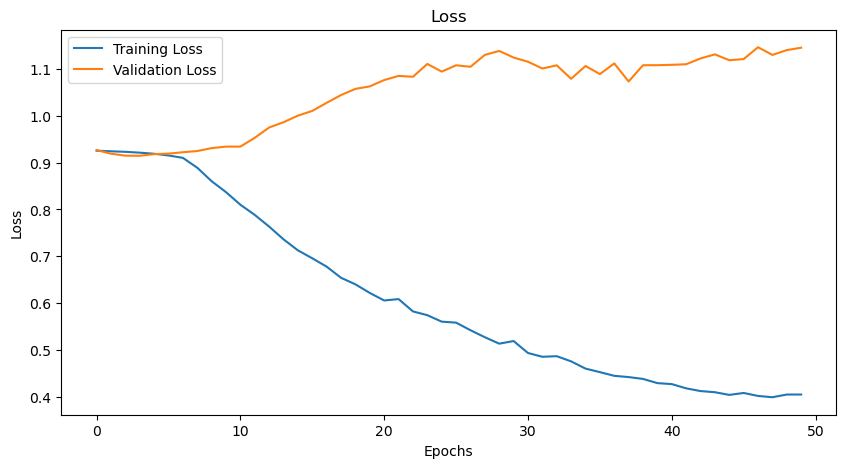

In [120]:
# Plot training training, validation and test loss
plt.figure(figsize=(10, 5))
plt.title("Loss")
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# This might point to the fact that the validation set is easier than training

In [124]:
# Find the classification metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
print(classification_report(y_test_arr, [i[2] > 0.5 for i in test_results]))
try:
    print(classification_report(y_val_arr, [i[2] > 0.5 for i in val_results]))
except:
    print(classification_report(y_val_resampled, [i[2] > 0.5 for i in val_results]))
try:
    print(classification_report(y_train_arr, [i[2] > 0.5 for i in train_results]))
except:
    print(classification_report(y_train_resampled, [i[2] > 0.5 for i in train_results]))

              precision    recall  f1-score   support

         0.0       0.93      0.36      0.52       802
         1.0       0.07      0.64      0.12        59

    accuracy                           0.38       861
   macro avg       0.50      0.50      0.32       861
weighted avg       0.87      0.38      0.49       861

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       409
         1.0       0.63      0.65      0.64       204

    accuracy                           0.75       613
   macro avg       0.72      0.73      0.72       613
weighted avg       0.76      0.75      0.75       613

              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63      6267
         1.0       0.32      0.37      0.34      3133

    accuracy                           0.52      9400
   macro avg       0.49      0.49      0.49      9400
weighted avg       0.54      0.52      0.53      9400



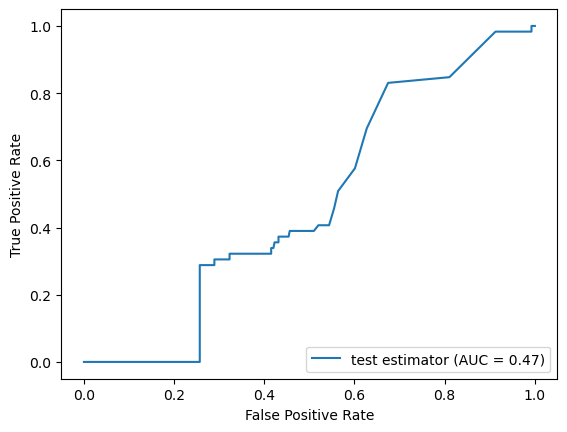

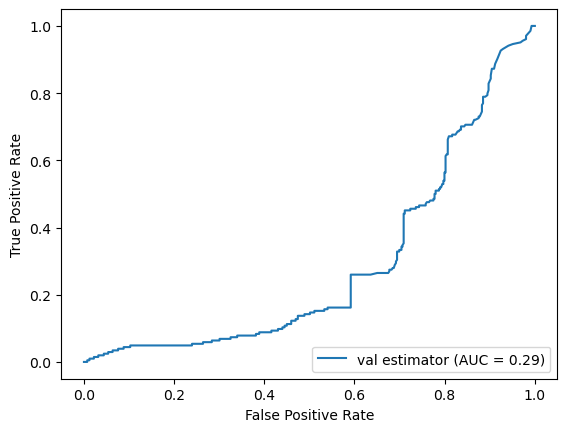

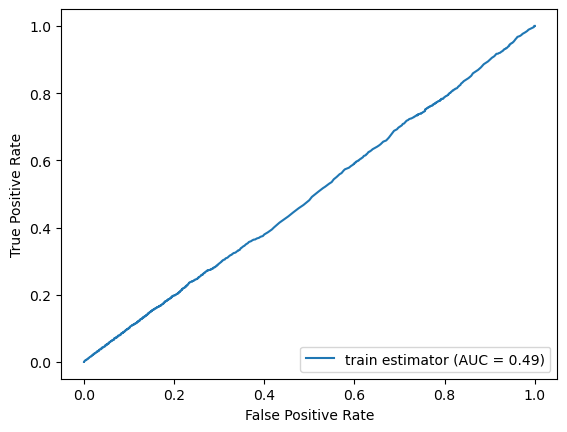

In [116]:
# Nice, we manage to get this! 

fpr, tpr, thresholds = roc_curve(y_test_arr, [i[2] for i in test_results])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='test estimator')
display.plot()
plt.show()

try:
    fpr, tpr, thresholds = roc_curve(y_val_arr, [i[2] for i in val_results])
except:
    fpr, tpr, thresholds = roc_curve(y_val_resampled, [i[2] for i in val_results])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='val estimator')
display.plot()
plt.show()

try:
    fpr, tpr, thresholds = roc_curve(y_train_arr, [i[2] for i in train_results])
except:
    fpr, tpr, thresholds = roc_curve(y_train_resampled, [i[2] for i in train_results])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='train estimator')
display.plot()
plt.show()

In [ ]:
y_test_pred = [i[2] for i in train_results]

[(0.0, 1, 0.5138541460037231),
 (0.0, 1, 0.5094764232635498),
 (1.0, 1, 0.5067540407180786),
 (0.0, 1, 0.5061250925064087),
 (1.0, 1, 0.5057670474052429),
 (0.0, 1, 0.5049260854721069),
 (1.0, 1, 0.5046392679214478),
 (0.0, 1, 0.5038437247276306),
 (0.0, 1, 0.5034523606300354),
 (1.0, 1, 0.5032376050949097),
 (0.0, 1, 0.5031346678733826),
 (0.0, 1, 0.5033332705497742),
 (1.0, 1, 0.5063323378562927),
 (1.0, 1, 0.5061970353126526),
 (0.0, 1, 0.5053950548171997),
 (0.0, 1, 0.5052956938743591),
 (0.0, 1, 0.5140970349311829),
 (1.0, 1, 0.5094250440597534),
 (1.0, 1, 0.5065321922302246),
 (0.0, 1, 0.5046583414077759),
 (1.0, 1, 0.5044401288032532),
 (1.0, 1, 0.5039314031600952),
 (1.0, 1, 0.5033150911331177),
 (1.0, 1, 0.5029976963996887),
 (0.0, 1, 0.502826452255249),
 (0.0, 1, 0.5027258992195129),
 (0.0, 1, 0.5029241442680359),
 (1.0, 1, 0.5053673982620239),
 (0.0, 1, 0.5054384469985962),
 (0.0, 1, 0.5049275755882263),
 (0.0, 1, 0.5043082237243652),
 (0.0, 1, 0.503761351108551),
 (1.0, 1, 

In [ ]:
for id, y_true, y_pred_arr in zip(id_test_arr, y_test_arr, train_results):
    print(f"{id} {y_true} {y_pred_arr[2]}")

p046927 0.0 0.5118077993392944
p046927 0.0 0.5065835118293762
p046927 0.0 0.5038002133369446
p046927 0.0 0.5017284750938416
p046927 0.0 0.500237226486206
p046927 0.0 0.49943724274635315
p046927 0.0 0.4989263415336609
p046927 0.0 0.49865958094596863
p046927 0.0 0.4985569715499878
p046927 0.0 0.4980018436908722
p046927 0.0 0.49785465002059937
p046927 0.0 0.49797701835632324
p046927 0.0 0.4981258809566498
p046927 0.0 0.49819129705429077
p046927 0.0 0.49815064668655396
p046927 0.0 0.4981405436992645
p046927 0.0 0.5120643973350525
p046927 0.0 0.507011890411377
p046927 0.0 0.5031826496124268
p046927 0.0 0.5011725425720215
p046927 0.0 0.5001004338264465
p046927 0.0 0.49953705072402954
p046927 0.0 0.4992370307445526
p046927 0.0 0.4990999102592468
p046927 0.0 0.4989928603172302
p046927 0.0 0.4989357590675354
p046927 0.0 0.4989197850227356
p046927 0.0 0.49891456961631775
p046927 0.0 0.4989088177680969
p046927 0.0 0.49875226616859436
p046927 0.0 0.49873873591423035
p046927 0.0 0.4987020790576935


In [57]:
# for each patient, find f1 score
d_result = {}
for id, y_true, y_pred_arr in zip(id_test_arr, y_test_arr, train_results):
    y_pred = y_pred_arr[2] > 0.5
    # For each y_true, y_pred, find out if TP, NP, TN, FN
    if id not in d_result:
        d_result[id] = {'TP':0, 'FP':0, 'TN':0, 'FN':0}
    if y_true == 1:  
        if y_pred is True:
            d_result[id]['TP'] += 1
        elif y_pred is False:
            d_result[id]['FN'] += 1
    else: 
        if y_pred is True:
            d_result[id]['FP'] += 1
        elif y_pred is False:
            d_result[id]['TN'] += 1

test_result_df = pd.DataFrame(d_result).T
test_result_df['precision'] = test_result_df['TP'] / (test_result_df['TP'] + test_result_df['FP'])
test_result_df['recall'] = test_result_df['TP'] / (test_result_df['TP'] + test_result_df['FN'])
test_result_df['F1'] = 2 * (test_result_df['precision'] * test_result_df['recall']) / (test_result_df['precision'] + test_result_df['recall'])
test_result_df

,TP,FP,TN,FN,precision,recall,F1
p046927,18,237,0,0,0.070588,1.0,0.131868
p082104,17,55,0,0,0.236111,1.0,0.382022
p086678,6,165,0,0,0.035088,1.0,0.067797
p087675,18,345,0,0,0.049587,1.0,0.094488


In [2]:
# Training data
plot_waveform(record_name = 'p099756-2191-12-23-02-00n',ca_time_str = '2191-12-23 09:53:00')


NameError: name 'plot_waveform' is not defined

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_68778/2491336164.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p063762-2181-12-04-03-58n', 'n_sig': 9, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 13587, 'base_time': datetime.time(3, 58, 44), 'base_date': datetime.date(2181, 12, 4), 'comments': ['Location: ccu'], 'sig_name': ['HR', 'RESP', 'PULSE', 'PVC Rate per Minute', 'SpO2', 'ST V', 'NBP Mean', 'NBP Dias', 'NBP Sys'], 'p_signal': array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['3326564n.dat', '3326564n.dat', '3326564n.dat', '3326564n.dat', '3326564n.dat', '3326564n.dat', '3326564n.dat', '3326564n.dat', '3326564n.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16'], 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'skew': [None, None, None, None,

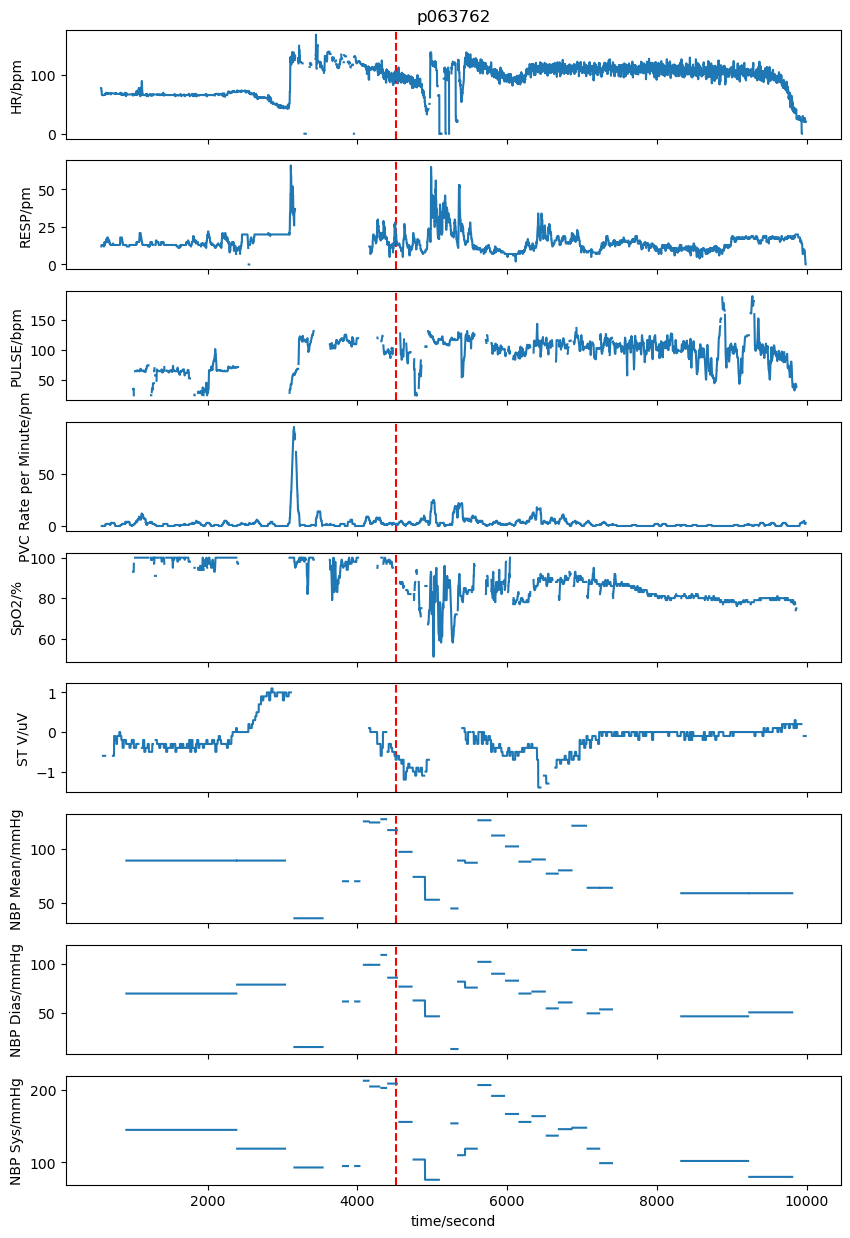

In [221]:
# Training data
plot_waveform(record_name = 'p063762-2181-12-04-03-58n',ca_time_str = '2181-12-04 04:45:00')


/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_68778/2491336164.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p086678-2196-06-07-00-34n', 'n_sig': 9, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 67819, 'base_time': datetime.time(0, 34, 36), 'base_date': datetime.date(2196, 6, 7), 'comments': ['Location: ccu'], 'sig_name': ['HR', 'RESP', 'PULSE', 'PVC Rate per Minute', 'SpO2', 'ST V', 'NBP Mean', 'NBP Dias', 'NBP Sys'], 'p_signal': array([[ nan,  nan,  60., ...,  nan,  nan,  nan],
       [ nan,  nan,  60., ...,  86.,  65., 145.],
       [ 62.,  nan,  60., ...,  86.,  65., 145.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16'], 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1, 1, 1

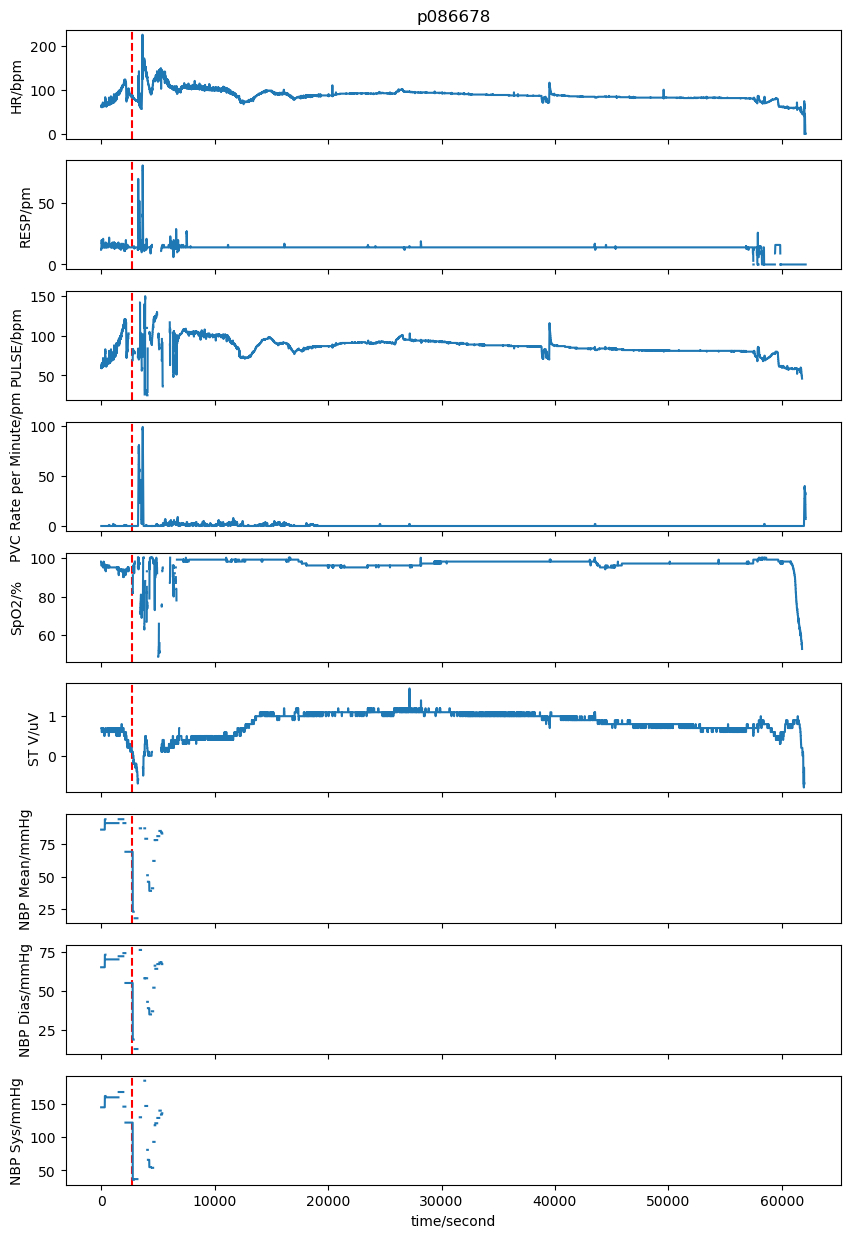

In [216]:
# Training data
plot_waveform(record_name = 'p086678-2196-06-07-00-34n',ca_time_str = '2196-06-07 01:20:00')

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_68778/2491336164.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p087675-2104-12-05-03-53n', 'n_sig': 8, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 137280, 'base_time': datetime.time(3, 53, 10), 'base_date': datetime.date(2104, 12, 5), 'comments': ['Location: sicu'], 'sig_name': ['HR', 'RESP', 'PULSE', 'PVC Rate per Minute', 'SpO2', 'NBP Mean', 'NBP Dias', 'NBP Sys'], 'p_signal': array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['3591887n.dat', '3591887n.dat', '3591887n.dat', '3591887n.dat', '3591887n.dat', '3591887n.dat', '3591887n.dat', '3591887n.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16'], 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1, 1], 'skew': [None, None, None, None, None, None, None, None], 'byte

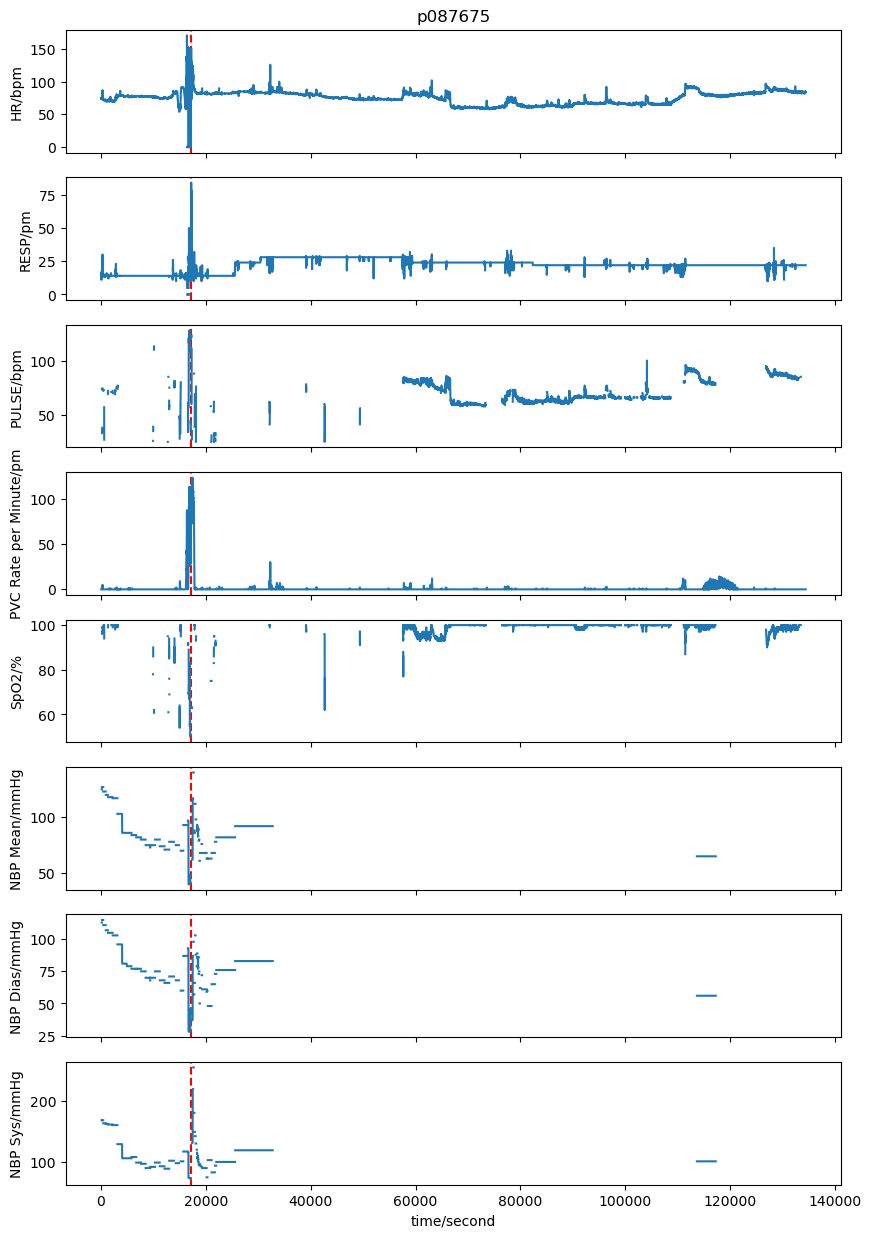

In [215]:
# Testing data
plot_waveform(record_name = 'p087675-2104-12-05-03-53n',ca_time_str = '2104-12-05 08:40:00')

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_68778/2491336164.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p086678-2196-06-07-00-34n', 'n_sig': 9, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 67819, 'base_time': datetime.time(0, 34, 36), 'base_date': datetime.date(2196, 6, 7), 'comments': ['Location: ccu'], 'sig_name': ['HR', 'RESP', 'PULSE', 'PVC Rate per Minute', 'SpO2', 'ST V', 'NBP Mean', 'NBP Dias', 'NBP Sys'], 'p_signal': array([[ nan,  nan,  60., ...,  nan,  nan,  nan],
       [ nan,  nan,  60., ...,  86.,  65., 145.],
       [ 62.,  nan,  60., ...,  86.,  65., 145.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat', '3114082n.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16'], 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1, 1, 1

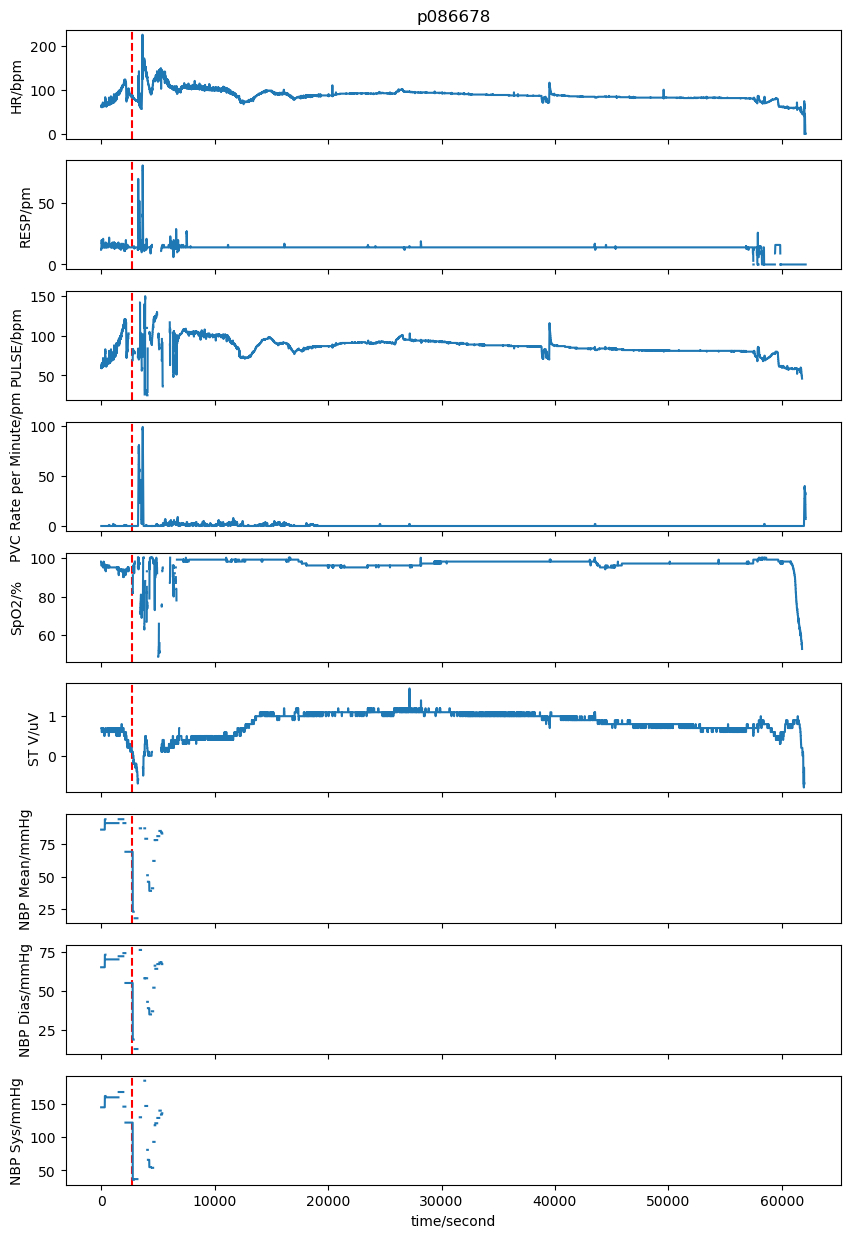

In [214]:
# Testing data
# dude died at the end
plot_waveform(record_name = 'p086678-2196-06-07-00-34n',ca_time_str = '2196-06-07 01:20:00')

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_68778/2491336164.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p082104-2177-04-29-16-16n', 'n_sig': 4, 'fs': 0.0166666666667, 'counter_freq': 125.0, 'base_counter': None, 'sig_len': 449, 'base_time': datetime.time(16, 16, 25), 'base_date': datetime.date(2177, 4, 29), 'comments': ['Location: sicu'], 'sig_name': ['HR', 'RESP', 'PULSE', 'CVP'], 'p_signal': array([[         nan,          nan,  69.33428878,          nan],
       [118.63984047,  25.13193914,  58.63282994,          nan],
       [111.066279  ,  23.48307645,  70.08281999,          nan],
       ...,
       [110.7830278 ,  26.11646877,          nan,  10.96682409],
       [ 91.9324333 ,  19.17388903,          nan,  12.21664731],
       [ 43.71611153,   6.06428355,          nan,  16.23334822]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['3209370n.dat', '3209370n.dat', '3209370n.dat', '3209370n.dat'], 'fmt': ['16', '16', '16', '16'], 'samps_per_frame': [1, 1, 1, 1], 'skew': [None, None, None, None], 'byte_offset': [None, None, None, None], 'adc_gai

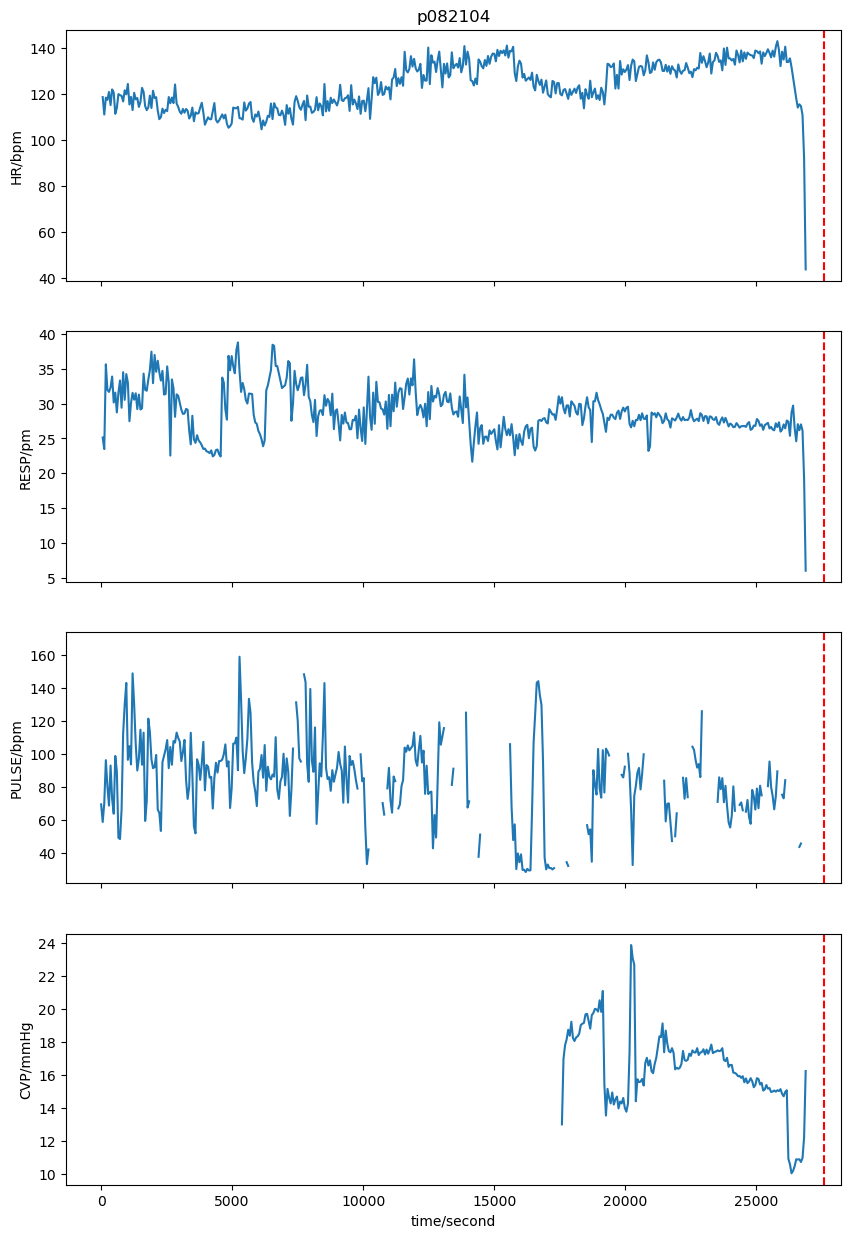

In [213]:
# Testing data
# plot_waveform('',ca_time_str = '2104-12-05 08:40:00')
# This is a tough case
plot_waveform(record_name = 'p082104-2177-04-29-16-16n',ca_time_str = '2177-04-29 23:56:00')

In [164]:
d_result

{'p041035': {'TP': 0, 'FP': 41, 'TN': 0, 'FN': 0},
 'p082104': {'TP': 17, 'FP': 55, 'TN': 0, 'FN': 0},
 'p086678': {'TP': 6, 'FP': 0, 'TN': 0, 'FN': 0},
 'p087675': {'TP': 18, 'FP': 27, 'TN': 0, 'FN': 0}}

In [218]:
# Find the F1-score of test set per patient ID
from sklearn.metrics import f1_score

f1_scores = [] 

f1_scores.append(f1_score(y_test_arr, [i[2] > 0.5 for i in test_results]))


# def get_f1_score_per_patient(y_true, y_pred, patient_id):
#     f1_scores = []
#     for i in np.unique(patient_id):
#         f1_scores.append(f1_score(y_true[patient_id == i], y_pred[patient_id == i]))
#     return f1_scores


[(1.0, 1, 0.5259827971458435),
 (0.0, 1, 0.5076486468315125),
 (1.0, 0, 0.48920515179634094),
 (0.0, 0, 0.47702956199645996),
 (0.0, 0, 0.4687967598438263),
 (0.0, 0, 0.4600192904472351),
 (0.0, 0, 0.45205482840538025),
 (1.0, 0, 0.4439616799354553),
 (0.0, 0, 0.43936601281166077),
 (0.0, 0, 0.4351256787776947),
 (1.0, 0, 0.4339609444141388),
 (0.0, 0, 0.43525198101997375),
 (0.0, 0, 0.43680715560913086),
 (1.0, 0, 0.4369819462299347),
 (1.0, 0, 0.43831539154052734),
 (0.0, 0, 0.4412383437156677),
 (1.0, 1, 0.5200093388557434),
 (0.0, 0, 0.49801531434059143),
 (1.0, 0, 0.4794587194919586),
 (1.0, 0, 0.46486324071884155),
 (0.0, 0, 0.4541299343109131),
 (1.0, 0, 0.4485325217247009),
 (1.0, 0, 0.4477902054786682),
 (0.0, 0, 0.44638898968696594),
 (1.0, 0, 0.44570839405059814),
 (1.0, 0, 0.44086623191833496),
 (0.0, 0, 0.43775370717048645),
 (0.0, 0, 0.43456342816352844),
 (0.0, 0, 0.4326268136501312),
 (0.0, 0, 0.43105849623680115),
 (0.0, 0, 0.431530237197876),
 (0.0, 0, 0.4334518611431

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


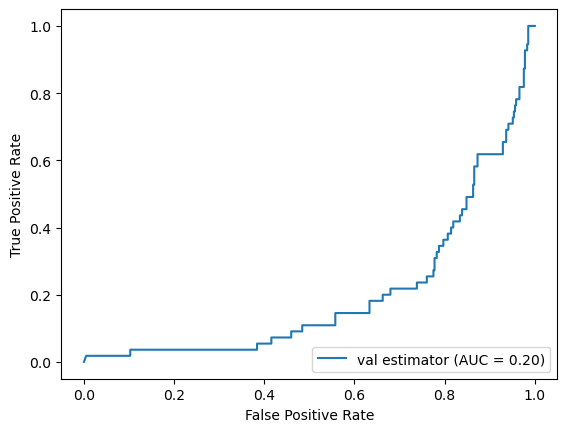

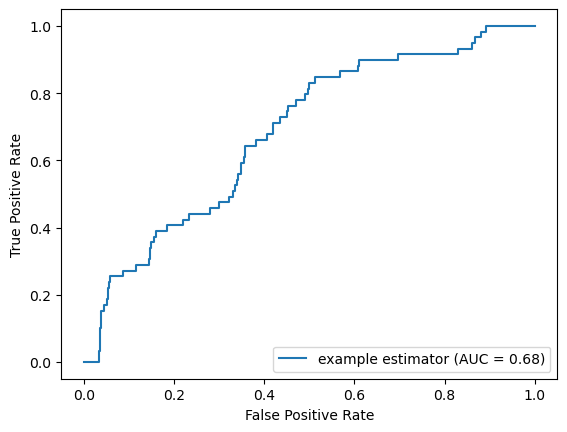

In [42]:
# learning an sklearn model and see how the result is like.
# This is an attempt to see if there is a bug with the data, or a bug with the model


logreg = LogisticRegression(max_iter=5000)
logreg.fit(x_train_arr.reshape(x_train_arr.shape[0],1200), y_train_arr)

# Make prediction on validation set
y_pred = logreg.predict_proba(x_val_arr.reshape(x_val_arr.shape[0],1200))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val_arr, y_pred[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='valid')
display.plot()
plt.show()

# Make prediction on validation set
y_pred = logreg.predict_proba(x_test_arr.reshape(x_test_arr.shape[0],1200))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_arr, y_pred[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='test')
display.plot()
plt.show()


# Result shows that there are indeed signals to be learned from the data.
# This indicates that there is potentially a bug with the model

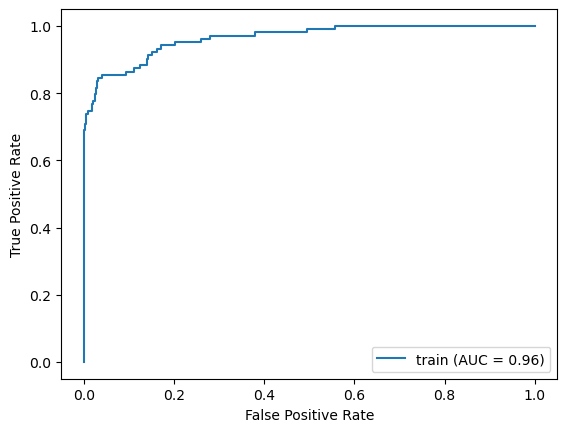

In [44]:
# Make prediction on validation set
y_pred = logreg.predict_proba(x_train_arr.reshape(x_train_arr.shape[0],1200))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_train_arr, y_pred[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='train')
display.plot()
plt.show()

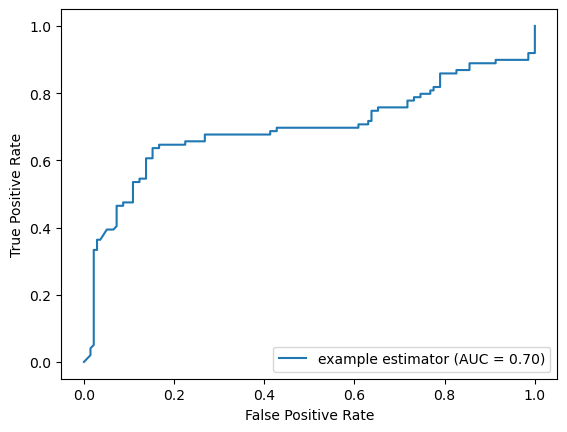

In [58]:
# learning an sklearn model and see how the result is like.
# This is an attempt to see if there is a bug with the data, or a bug with the model
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay,roc_curve,auc

logreg = SVC(probability=True, C = 0.01, kernel = 'sigmoid')
logreg.fit(x_train_arr.reshape(178,1200), y_train_arr)

# Make prediction on validation set
y_pred = logreg.predict_proba(x_val_arr.reshape(237,1200))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val_arr, y_pred[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

# Result shows that there are indeed signals to be learned from the data.
# This indicates that there is potentially a bug with the model

In [ ]:
# Ther is clearly a bug in here somewhere.
# We will try to figure it out

In [414]:
positive_df

,HR,RESP,PULSE,CVP,etco2,SpO2,AWRR,NBP_Mean,NBP_Dias,NBP_Sys
2191-12-23 09:00:00,136.528086,14.483004,135.112286,12.022364,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 09:00:05,136.546091,14.341348,135.124476,12.025002,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 09:00:10,136.564095,14.199692,135.136666,12.027641,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 09:00:15,136.582099,14.058036,135.148856,12.030280,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 09:00:20,136.600103,13.916381,135.161046,12.032919,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2191-12-23 10:54:40,76.705133,12.373183,31.499974,290.224047,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 10:54:45,75.506674,11.845728,31.499974,290.279462,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 10:54:50,74.308216,11.318273,31.499974,290.334876,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 10:54:55,73.109757,10.790818,31.499974,290.390291,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
get_record('p099756-2191-12-23-02-00n').to_dataframe()

,HR,RESP,PULSE,CVP
2191-12-23 02:00:23.000000000,106.367395,12.957952,NaN,NaN
2191-12-23 02:01:22.999999999,102.833849,12.132937,69.332174,NaN
2191-12-23 02:02:22.999999998,106.881934,23.366485,102.882560,NaN
2191-12-23 02:03:22.999999997,102.017978,20.616179,107.375118,NaN
2191-12-23 02:04:22.999999996,107.095140,15.366291,124.571798,NaN
...,...,...,...,...
2191-12-23 10:56:22.999999464,42.035830,2.067905,NaN,290.468324
2191-12-23 10:57:22.999999463,72.001320,10.282787,NaN,290.002388
2191-12-23 10:58:22.999999462,78.249697,13.782968,NaN,248.149544
2191-12-23 10:59:22.999999461,64.149628,14.200076,NaN,42.336874


In [104]:
patient_id

'p099756'

In [415]:
a,b,c=get_record_df('p041035-2135-02-06-08-02n')
b

,HR,RESP,PULSE,SpO2,NBP Mean,NBP Dias,NBP Sys,etco2,CVP,AWRR
2135-02-06 09:14:10,69.0,21.0,68.0,98.0,77.0,63.0,121.0,0,0,0
2135-02-06 09:14:15,69.0,21.0,69.0,99.0,77.0,63.0,121.0,0,0,0
2135-02-06 09:14:20,69.0,21.0,69.0,99.0,77.0,63.0,121.0,0,0,0
2135-02-06 09:14:25,69.0,21.0,69.0,99.0,77.0,63.0,121.0,0,0,0
2135-02-06 09:14:30,70.0,21.0,69.0,99.0,77.0,63.0,121.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2135-02-06 11:08:45,69.0,14.0,69.0,96.0,76.0,61.0,120.0,0,0,0
2135-02-06 11:08:50,69.0,14.0,68.0,96.0,76.0,61.0,120.0,0,0,0
2135-02-06 11:08:55,70.0,14.0,69.0,96.0,76.0,61.0,120.0,0,0,0
2135-02-06 11:09:00,70.0,14.0,71.0,96.0,76.0,61.0,120.0,0,0,0


In [32]:
# We find the lowest hangest fruit. 
valid_records_list

['p041035-2135-02-06-08-02n',
 'p050015-2138-12-20-19-42n',
 'p082104-2177-04-29-16-16n',
 'p082512-2114-12-22-08-46n',
 'p096060-2112-12-16-14-20n',
 'p099756-2191-12-23-02-00n']

In [78]:
get_record_df(record_name, base_time=None, ca_time=None)

NameError: name 'record_name' is not defined